In [49]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable as V
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [225]:
input_size = 784
hidden_size = 300
n_classes = 10
n_epochs = 20
batch_size = 64
learning_rate = 0.001

In [226]:
train_dataset = datasets.MNIST(root = '../data', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = '../data', train = False, transform = transforms.ToTensor())

In [227]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [228]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

60000
10000
938
157


In [229]:
image, label = iter(train_loader).next()
print(image.size())
print(type(image))
print(label.size())
print(type(label))

torch.Size([64, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([64])
<class 'torch.Tensor'>


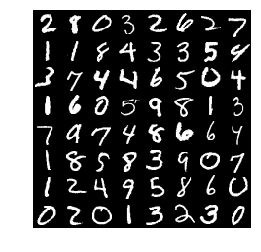

In [230]:
%matplotlib inline
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] → [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

images, labels = iter(train_loader).next()
images, labels = images[:64], labels[:64]
imshow(make_grid(images, nrow = 8, padding = 0))

In [231]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = F.dropout(out, 0.5)
        out = F.relu(self.l2(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.l3(out))
        out = F.dropout(out, 0.5)
        out = self.l4(out)
        return out

In [232]:
net = MLP(input_size, hidden_size, n_classes)
net.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [233]:
def train(train_loader):
    net.train()
    running_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = V(inputs.view(-1, 28*28)).cuda()
        targets = V(targets).cuda()
        
        pred = net(inputs)
        loss = loss_fn(pred, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
    
    train_loss = running_loss / (i + 1)
    return train_loss

In [234]:
def test(test_loader):
    net.eval()
    running_loss = 0
    correct = 0
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            inputs = V(inputs.view(-1, 28*28)).cuda()
            targets = V(targets).cuda()
        
            pred = net(inputs)
            loss = loss_fn(pred, targets)
        
        running_loss += loss.data.item()
        _, predicted = torch.max(pred.data, dim = 1)
        correct += (predicted == targets.data).float().sum()
    
    val_loss = running_loss / (i + 1)
    val_acc = correct / (batch_size * (i + 1))
    
    return val_loss, val_acc

In [235]:
losses = []
val_losses = []
val_acces = []
for epoch in range(n_epochs):
    loss = train(train_loader)
    val_loss, val_acc = test(test_loader)
    
    losses.append(loss)
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    
    if (epoch+1) % 1 == 0:
        print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f val_acc:%1.4f' % (epoch+1, n_epochs, loss, val_loss, val_acc))

epoch[1/20] loss:0.2632 val_loss:0.1137 val_acc:0.9590
epoch[2/20] loss:0.1004 val_loss:0.0945 val_acc:0.9657
epoch[3/20] loss:0.0675 val_loss:0.0902 val_acc:0.9677
epoch[4/20] loss:0.0530 val_loss:0.0781 val_acc:0.9725
epoch[5/20] loss:0.0421 val_loss:0.0800 val_acc:0.9725
epoch[6/20] loss:0.0348 val_loss:0.0902 val_acc:0.9706
epoch[7/20] loss:0.0296 val_loss:0.0824 val_acc:0.9714
epoch[8/20] loss:0.0262 val_loss:0.0803 val_acc:0.9738
epoch[9/20] loss:0.0215 val_loss:0.0790 val_acc:0.9747
epoch[10/20] loss:0.0217 val_loss:0.0748 val_acc:0.9773
epoch[11/20] loss:0.0178 val_loss:0.0801 val_acc:0.9772
epoch[12/20] loss:0.0180 val_loss:0.0930 val_acc:0.9742
epoch[13/20] loss:0.0160 val_loss:0.0936 val_acc:0.9751
epoch[14/20] loss:0.0146 val_loss:0.0930 val_acc:0.9748
epoch[15/20] loss:0.0122 val_loss:0.0875 val_acc:0.9772
epoch[16/20] loss:0.0133 val_loss:0.0839 val_acc:0.9774
epoch[17/20] loss:0.0105 val_loss:0.1416 val_acc:0.9690
epoch[18/20] loss:0.0128 val_loss:0.0852 val_acc:0.9798
e

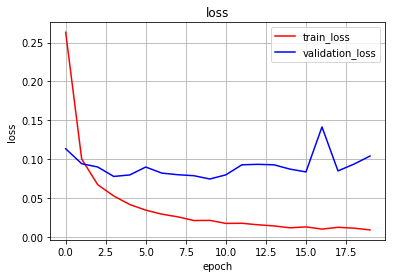

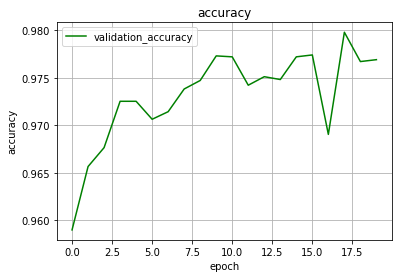

In [236]:
%matplotlib inline
plt.plot(range(n_epochs), losses, 'r-', label = 'train_loss')
plt.plot(range(n_epochs), val_losses, 'b-', label = 'validation_loss')
plt.legend()
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.plot(range(n_epochs), val_acces, 'g-', label = 'validation_accuracy')
plt.legend()
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [141]:
i

4